In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_original=pd.read_csv("C://Users//User//Downloads/Train_Time.csv")
test_original=pd.read_csv("C://Users//User//Downloads/Test_Time.csv")

In [9]:
train_original['Datetime']=pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime']=pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M')

In [ ]:
'''
5) Introduction to ARIMA model
ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).

Here p is the order of the autoregressive model(number of time lags)
d is the degree of differencing(number of times the data have had past values subtracted)
q is the order of moving average model. We will discuss more about these parameters in next section.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

What is a stationary time series?
There are three basic criterion for a series to be classified as stationary series :

The mean of the time series should not be a function of time. It should be constant.
The variance of the time series should not be a function of time.
THe covariance of the ith term and the (i+m)th term should not be a function of time.

Why do we have to make the time series stationary?
We make the series stationary to make the variables independent. Variables can be dependent in various ways, 
but can only be independent in one way. So, we will get more information when they are independent. 
Hence the time series must be stationary.

If the time series is not stationary, firstly we have to make it stationary. For doing so, 
we need to remove the trend and seasonality from the data. To learn more about stationarity you can refer this article: 
https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
'''

In [ ]:
'''
--->Parameter tuning for ARIMA model
First of all we have to make sure that the time series is stationary. 
If the series is not stationary, we will make it stationary.

---->Stationarity Check
We use Dickey Fuller test to check the stationarity of the series.
The intuition behind this test is that it determines how strongly a time series is defined by a trend.
The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis 
and say that the series is stationary.

We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, 
it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept
the null hypothesis (non-stationary).

Let’s make a function which we can use to calculate the results of Dickey-Fuller test.
'''

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    rolstd = pd.rolling_std(timeseries, window=24)
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

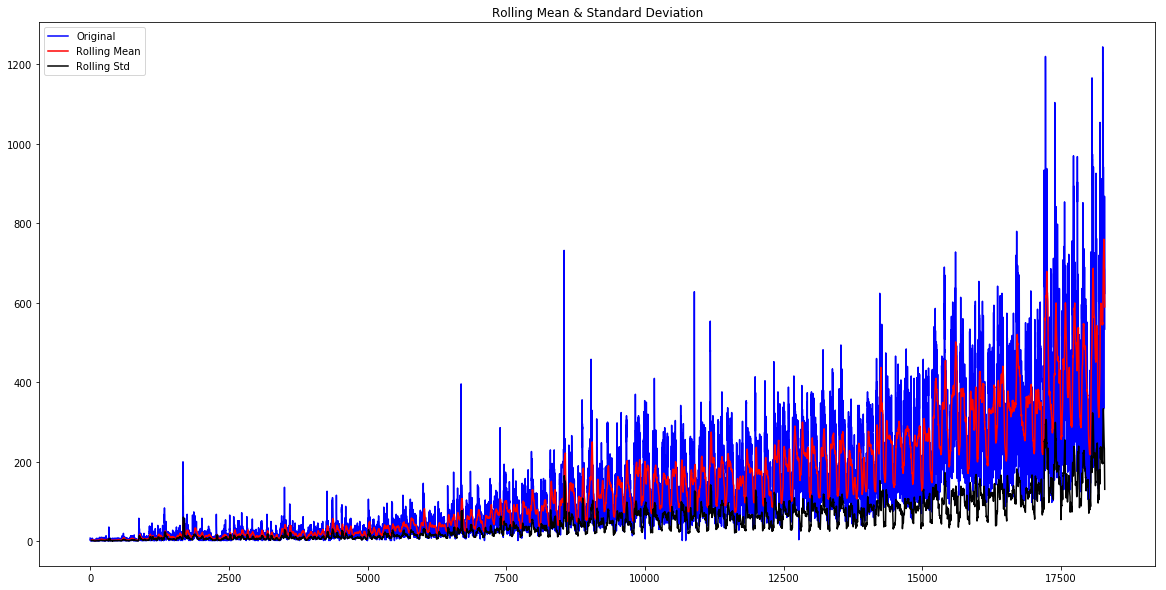

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [13]:
plt.figure(figsize = (20,10))
test_stationarity(train_original['Count'])

In [ ]:
'''
The statistics shows that the time series is stationary as Test Statistic < Critical value 
but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. 
For doing so, we need to remove the trend and seasonality from the data.

--->Removing Trend
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, 
for example log transformation.

We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that 
each day has 24 hours.
'''

In [14]:
train_original.index=train_original.Datetime
train_original.head()

,ID,Datetime,Count
Datetime,,,
2012-08-25 00:00:00,0,2012-08-25 00:00:00,8
2012-08-25 01:00:00,1,2012-08-25 01:00:00,2
2012-08-25 02:00:00,2,2012-08-25 02:00:00,6
2012-08-25 03:00:00,3,2012-08-25 03:00:00,2
2012-08-25 04:00:00,4,2012-08-25 04:00:00,2


In [15]:
train=train_original.loc['2012-08-25':'2014-06-24']
valid=train_original.loc['2014-06-25':'2014-09-25']#Splitting training and validation data

In [16]:
train.tail()

,ID,Datetime,Count
Datetime,,,
2014-06-24 19:00:00,16051,2014-06-24 19:00:00,398
2014-06-24 20:00:00,16052,2014-06-24 20:00:00,444
2014-06-24 21:00:00,16053,2014-06-24 21:00:00,406
2014-06-24 22:00:00,16054,2014-06-24 22:00:00,352
2014-06-24 23:00:00,16055,2014-06-24 23:00:00,390


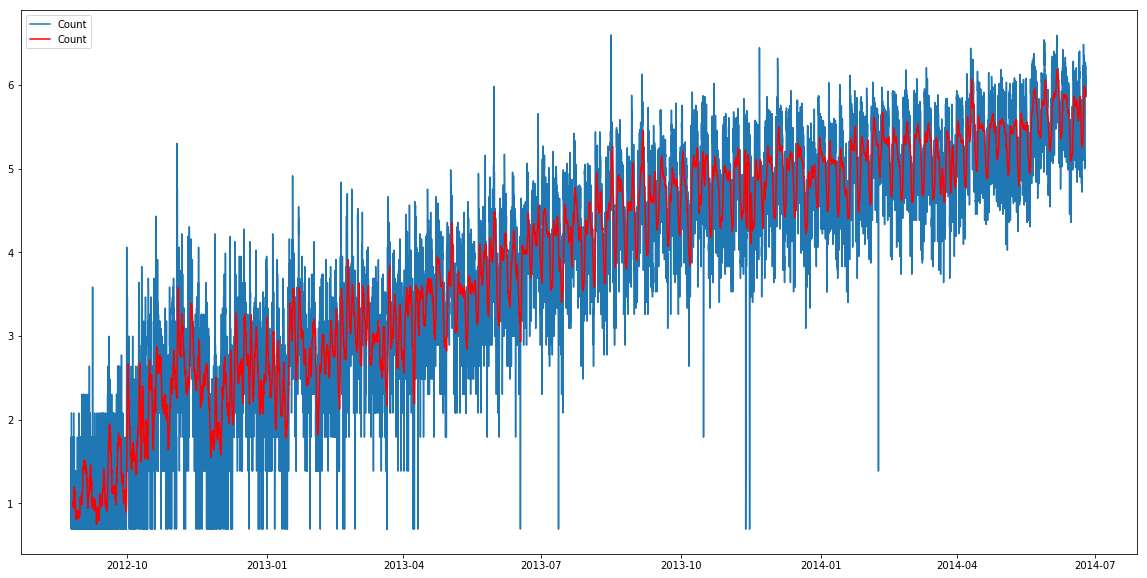

In [20]:
train_log = np.log(train['Count'])
valid_log = np.log(valid['Count'])
moving_avg = pd.rolling_mean(train_log, 24)
plt.figure(figsize = (20,10))
plt.plot(train_log)
plt.plot(moving_avg, color = 'red')
plt.legend(loc='best')
plt.show()

In [21]:
# So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

train_log_moving_avg_diff = train_log - moving_avg
train_log_moving_avg_diff.head()

Datetime
2012-08-25 00:00:00   NaN
2012-08-25 01:00:00   NaN
2012-08-25 02:00:00   NaN
2012-08-25 03:00:00   NaN
2012-08-25 04:00:00   NaN
Name: Count, dtype: float64

In [22]:
# Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.

train_log_moving_avg_diff.dropna(inplace = True)

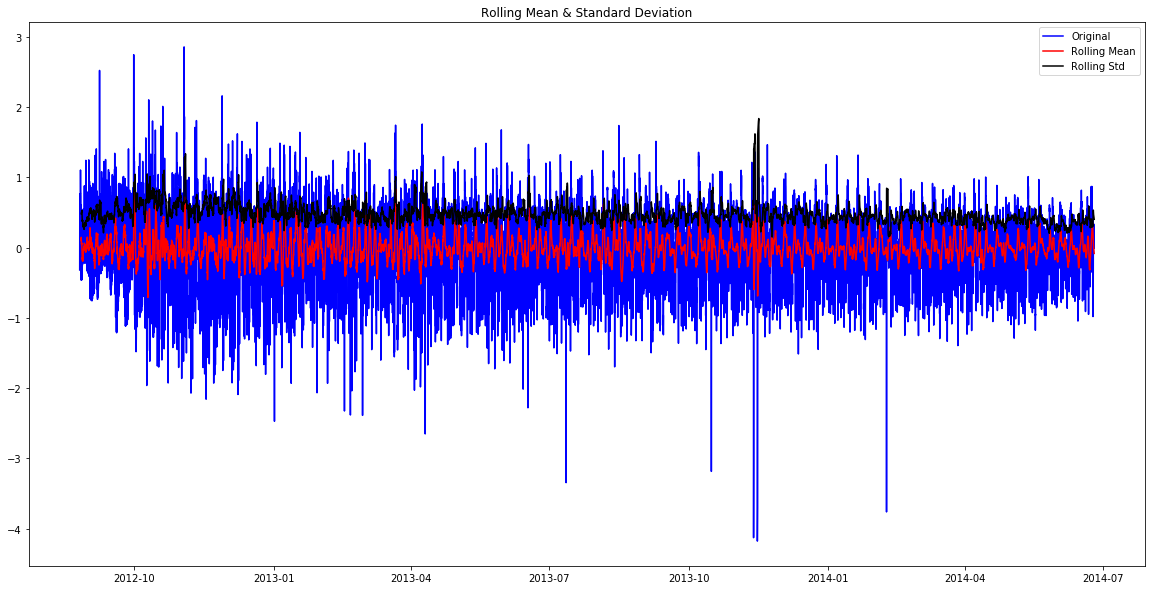

Results of Dickey-Fuller Test:
Test Statistic                   -22.470949
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    15989.000000
Critical Value (1%)               -3.430759
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [23]:
test_stationarity(train_log_moving_avg_diff)

In [ ]:
'''We can see that the Test Statistic is very smaller as compared to the Critical Value. 
    So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

Differencing can help to make the series stable and eliminate the trend.
'''

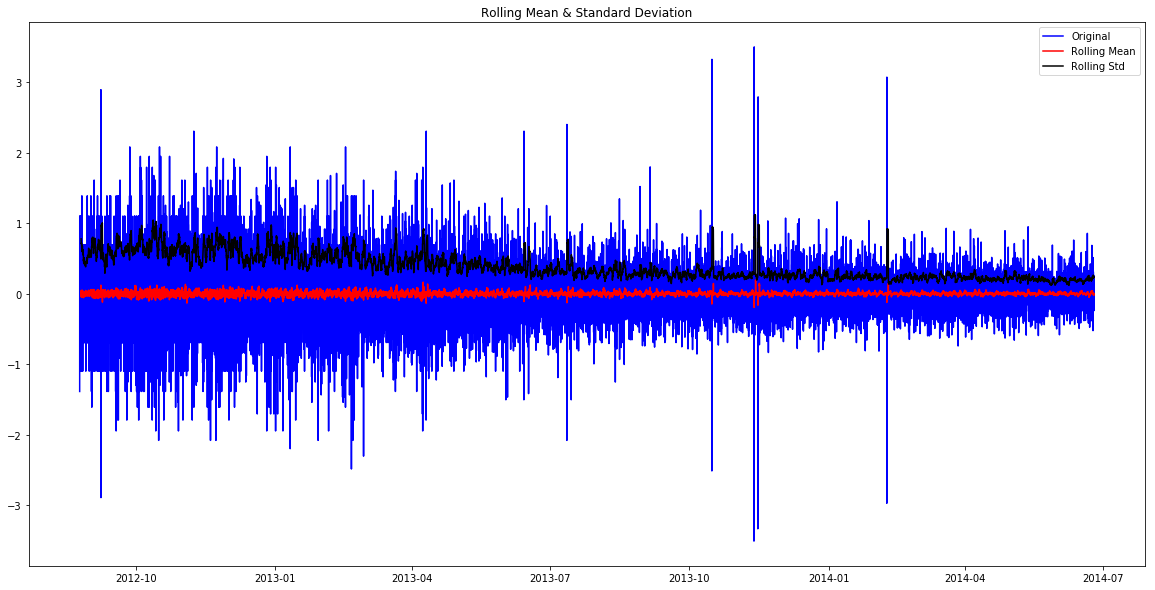

Results of Dickey-Fuller Test:
Test Statistic                   -28.579381
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    16011.000000
Critical Value (1%)               -3.430758
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [31]:
train_log_diff = train_log - train_log.shift(1)
test_stationarity(train_log_diff.dropna())

In [ ]:
'''
Now we will decompose the time series into trend and seasonality and will get the residual 
which is the random variation in the series.

Removing Seasonality
By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors 
(e.g., the quarter of the year, the month, or day of the week).
Seasonality is always of a fixed and known period.
We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.
'''

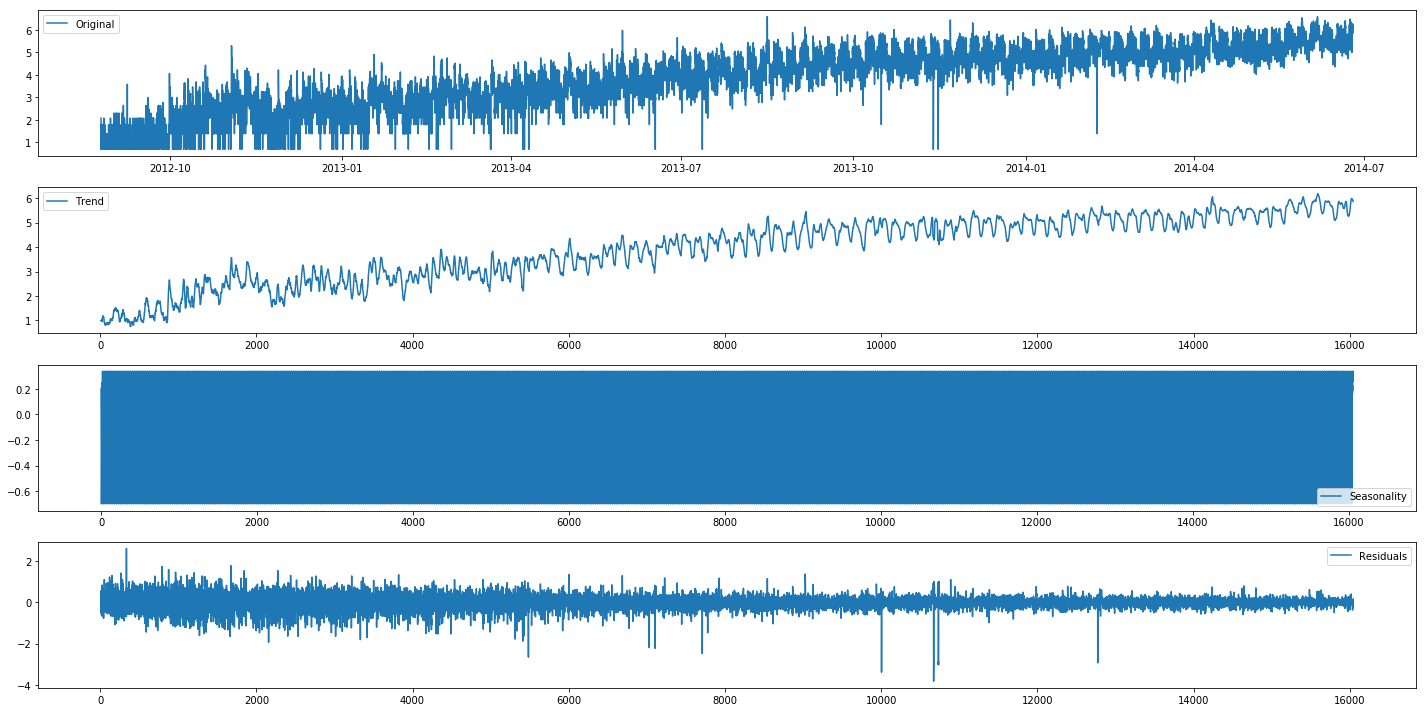

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
'''
We can see the trend, residuals and the seasonality clearly in the above graph. 
Seasonality shows a constant trend in counter.

Let’s check stationarity of residuals.'''

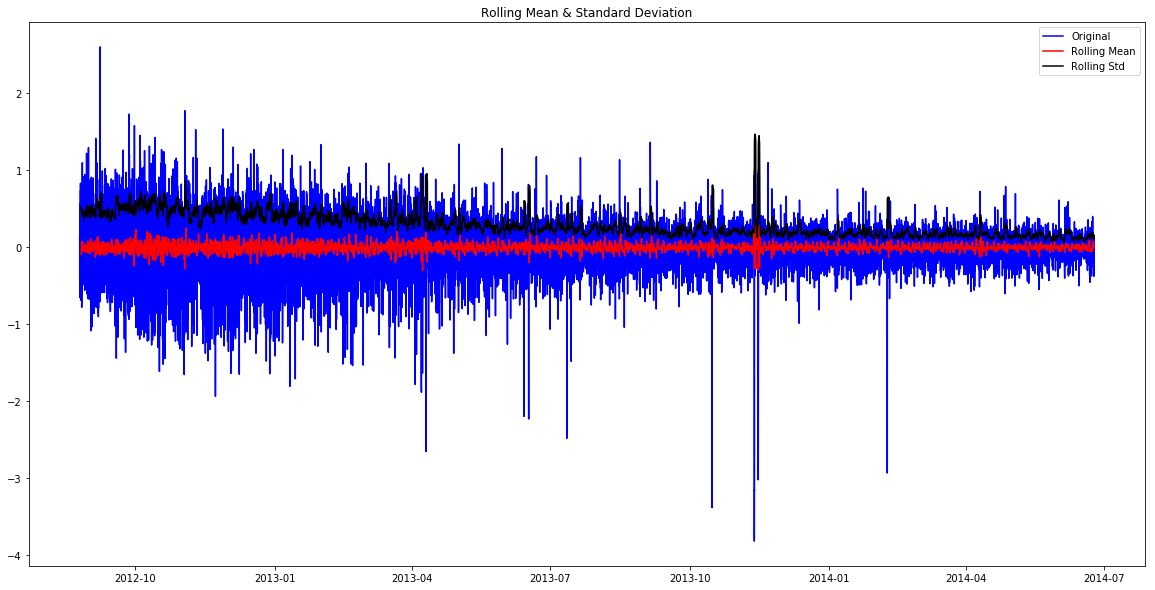

Results of Dickey-Fuller Test:
Test Statistic                   -31.326116
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    15988.000000
Critical Value (1%)               -3.430759
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [29]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

In [ ]:
'''
It can be interpreted from the results that the residuals are stationary.

Now we will forecast the time series using different models.
'''

In [ ]:
'''
Forecasting the time series using ARIMA
First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the 
p,d,q parameters.

To find the optimized values of these parameters, we will use ACF(Autocorrelation Function)
and PACF(Partial Autocorrelation Function) graph.

ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the 
variations already explained by the intervening comparisons.
'''

In [32]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

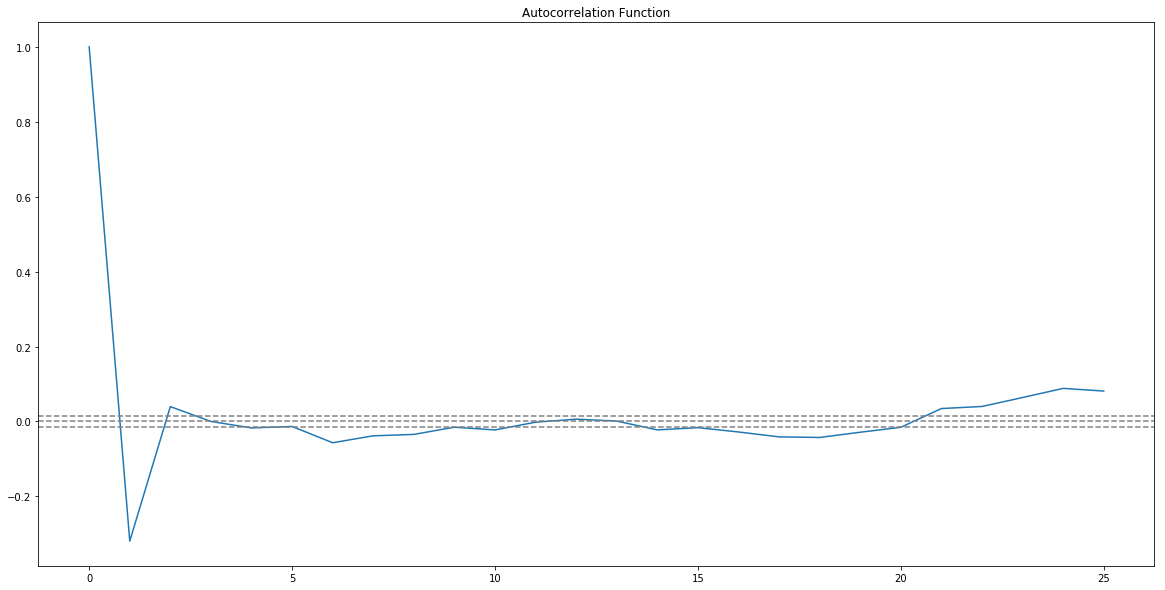

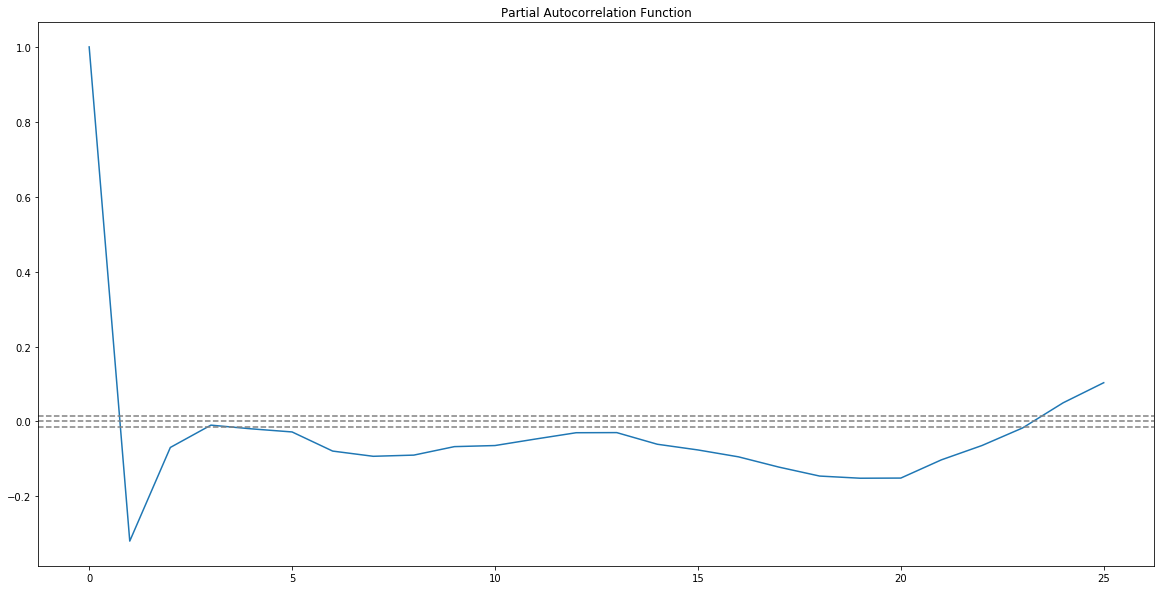

In [33]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

In [ ]:
'''
p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. 
It can be noticed that in this case p=1.

q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. 
It can be noticed that in this case q=1.

Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them 
together.



AR model
The autoregressive model specifies that the output variable depends linearly on its own previous values
'''

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


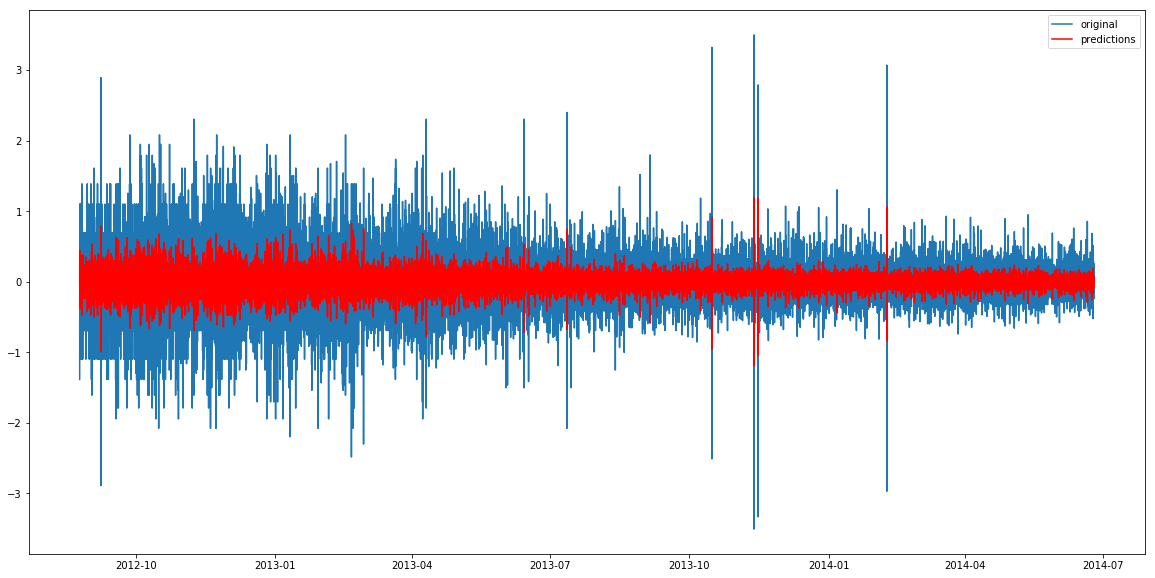

In [34]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_AR.fittedvalues, color='red', label='predictions')
plt.legend(loc='best')
plt.show()

In [ ]:
'''
Lets plot the validation curve for AR model.

We have to change the scale of the model to the original scale.

First step would be to store the predicted results as a separate series and observe it.
'''

In [36]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25")
AR_predict=AR_predict.cumsum().shift().fillna(0)
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0)


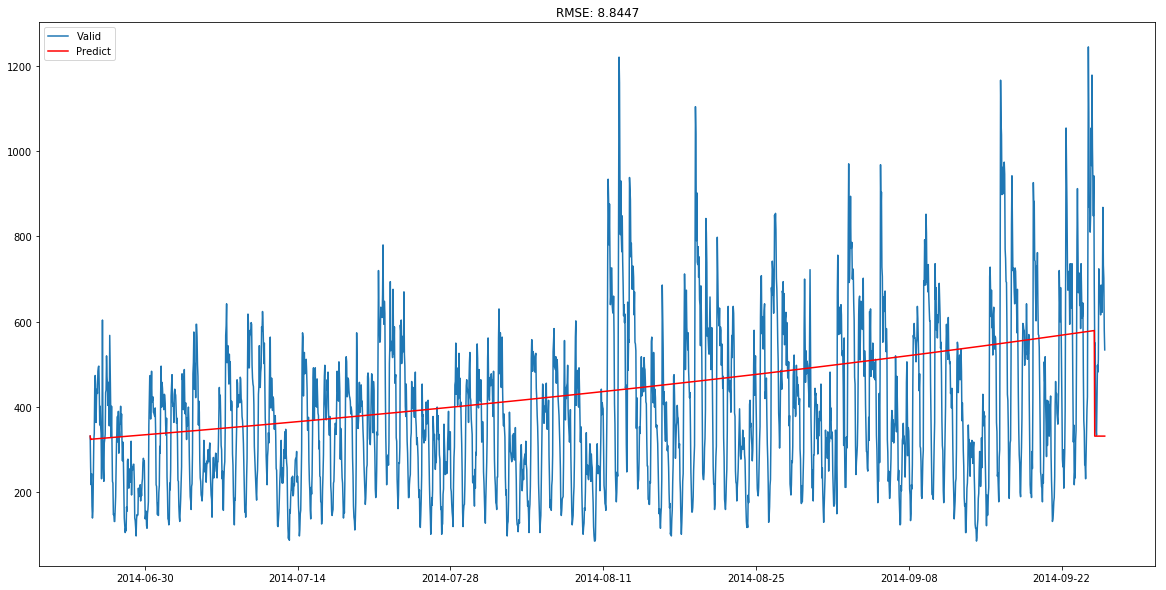

In [37]:
AR_predict = np.exp(AR_predict1)
plt.plot(valid['Count'], label = "Valid")
plt.plot(AR_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))
plt.show()

In [ ]:
'''
MA model
The moving-average model specifies that the output variable depends linearly on the current and various past values
of a stochastic (imperfectly predictable) term.
'''

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


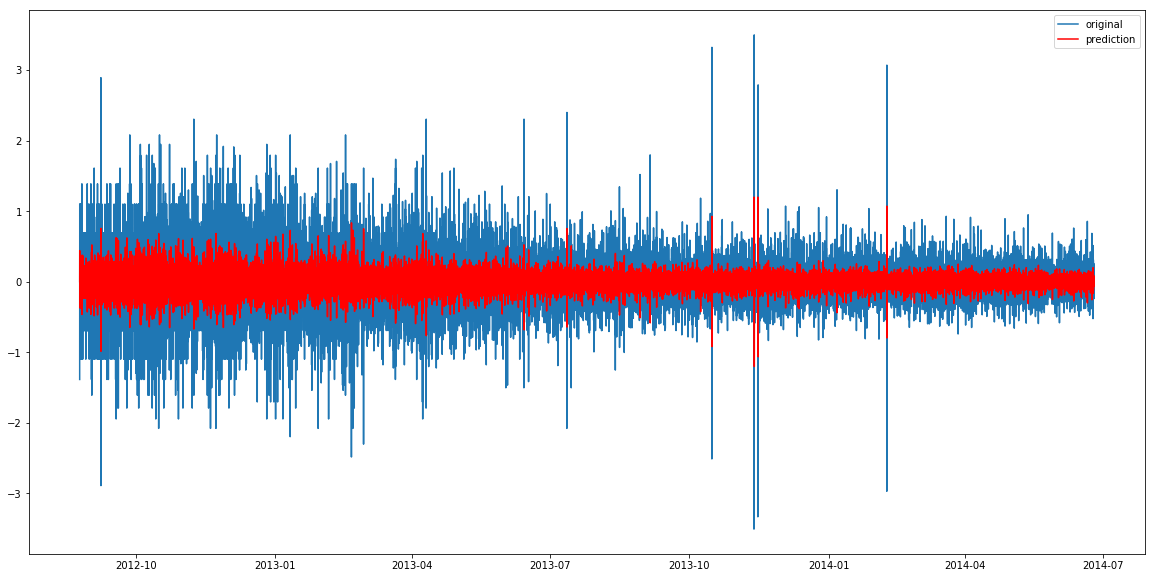

In [38]:
model = ARIMA(train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_MA.fittedvalues, color='red', label='prediction')
plt.legend(loc='best')
plt.show()

In [39]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)

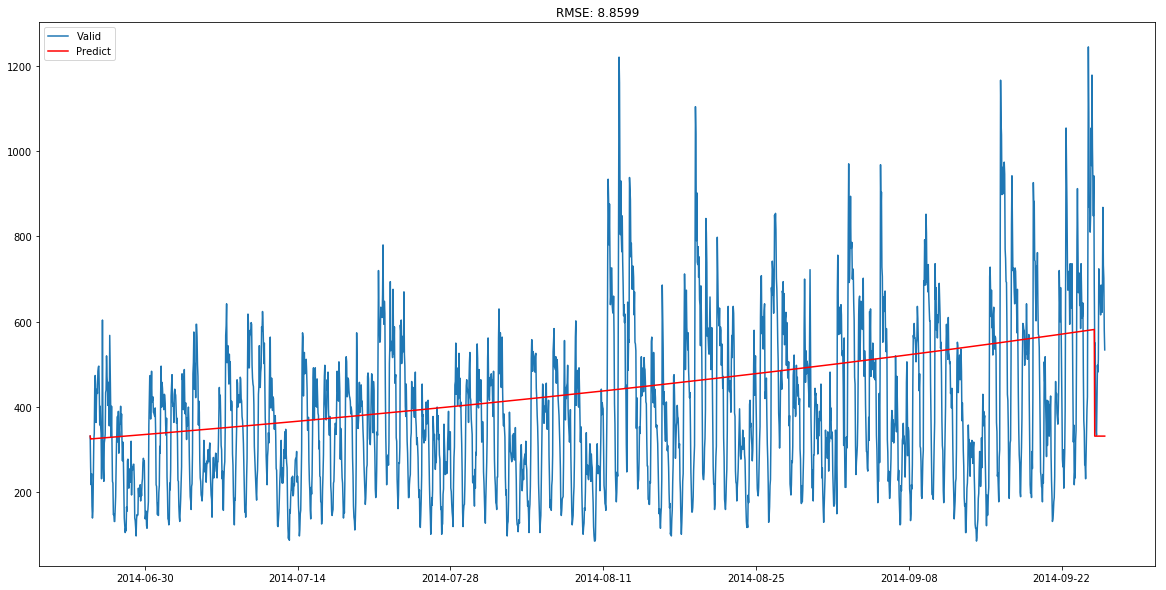

In [40]:
plt.plot(valid['Count'], label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


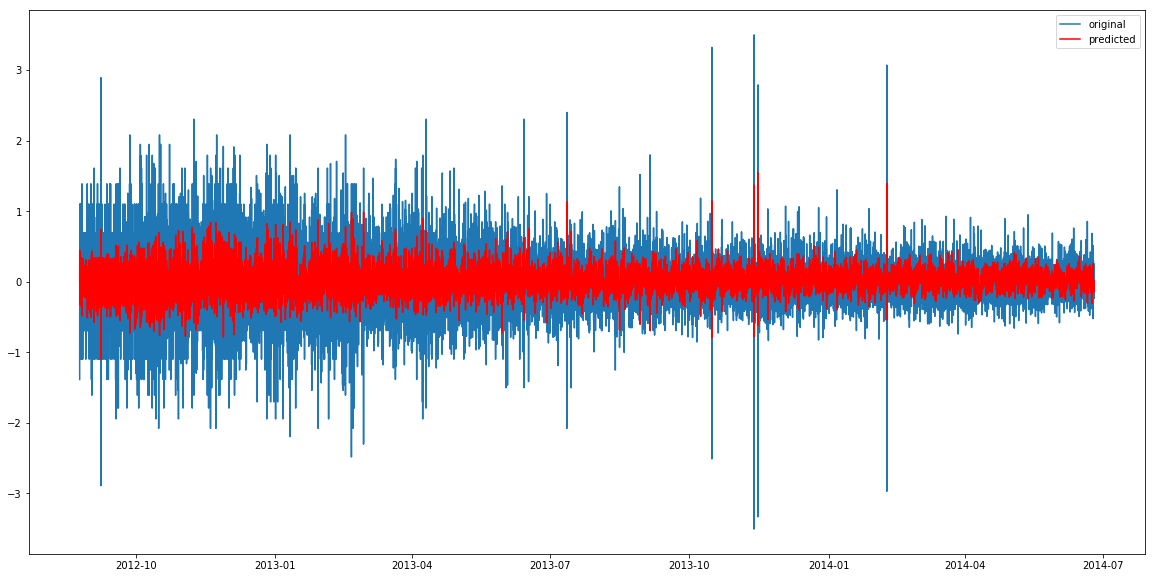

In [42]:
# COMBINED MODEL(AR+MA)
model = ARIMA(train_log, order=(2, 1, 2))  # Here you can see p=2, q=2 both are non_zero
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted')
plt.legend(loc='best')
plt.show()

In [43]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [50]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set, label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set))/given_set.shape[0]))
    plt.show()

In [45]:
# predicting on validation set
ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")

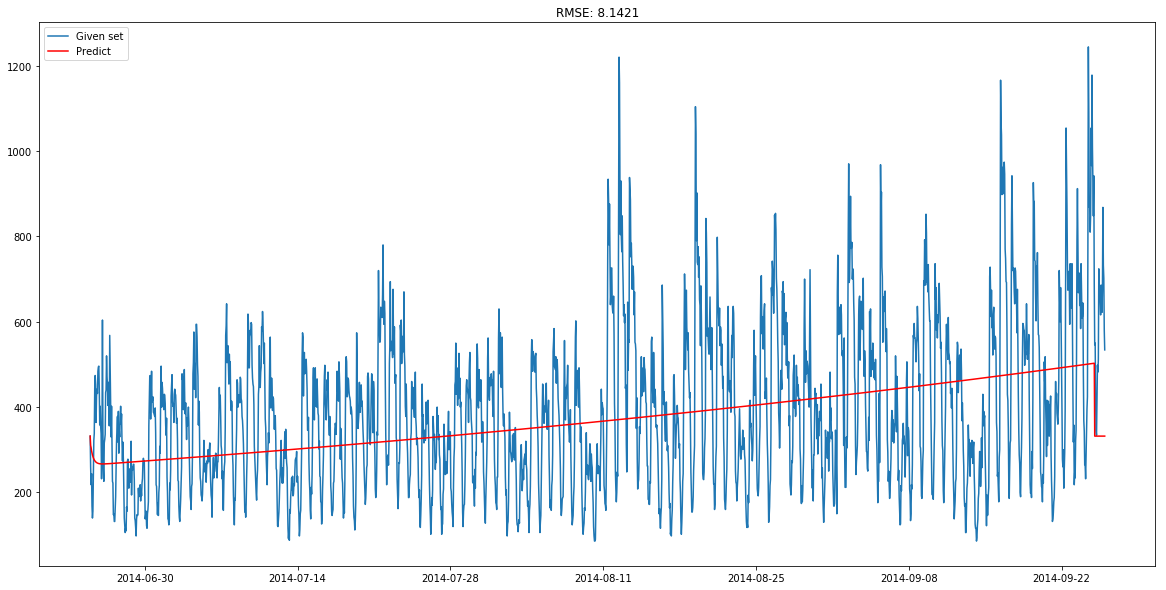

In [46]:
check_prediction_diff(ARIMA_predict_diff, valid)